<b>Import libraries</b>

In [3]:
import sys
import types
from ibm_botocore.client import Config
import ibm_boto3

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.style.use('ggplot') # plot style - more soft colors

from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn import metrics

# !conda install -c conda-forge pydotplus -y
# !conda install -c conda-forge python-graphviz -y
from sklearn.externals.six import StringIO
import pydotplus
import matplotlib.image as mpimg
from sklearn import tree
%matplotlib inline 

In [4]:
# @hidden_cell
# The following code contains the credentials for a file in your IBM Cloud Object Storage.
# Credentials
client_1bcdfcb7442a4684a9c961ee5ae401ae = ibm_boto3.client(service_name='s3',
    ibm_api_key_id='<**REPLACE_WITH_YOUR_BUCKET_ID**>',
    ibm_auth_endpoint="https://iam.ng.bluemix.net/oidc/token",
    config=Config(signature_version='oauth'),
    endpoint_url='https://s3-api.us-geo.objectstorage.service.networklayer.com')
bucket='<**REPLACE_WITH_YOUR_BUCKET_ID**>'

<b>Download DF 311 + Date parsing</b>

In [5]:
client_1bcdfcb7442a4684a9c961ee5ae401ae.download_file(Bucket=bucket,Key='df_raw_cos.pkl',Filename='./df_raw_local.pkl')
df = pd.read_pickle('./df_raw_local.pkl')
df['created_date'] = pd.to_datetime(df['created_date'], dayfirst=False, errors='coerce').dt.date #parse date
df['closed_date'] = pd.to_datetime(df['closed_date'], dayfirst=False, errors='coerce').dt.date #parse date

<b>Data exploration & Wrangling</b>

In [6]:
print('Main DF 311 shape: ', df.shape[0], ' rows and ',df.shape[1],' columns')

Main DF 311 shape:  5839608  rows and  15  columns


In [7]:
df.head(3)

,created_date,unique_key,complaint_type,incident_zip,incident_address,street_name,address_type,city,resolution_description,borough,latitude,longitude,closed_date,location_type,status
0,2013-01-11,24765056,HPD Literature Request,NaN,NaN,NaN,NaN,NaN,The literature has been mailed. If it has not ...,Unspecified,NaN,NaN,2013-01-11,NaN,Closed
1,2018-08-11,39981834,PAINT/PLASTER,11429.0,104-34 219 STREET,219 STREET,ADDRESS,Queens Village,The Department of Housing Preservation and Dev...,QUEENS,40.711539,-73.735724,2019-03-30,RESIDENTIAL BUILDING,Closed
2,2018-08-11,39982698,APPLIANCE,11429.0,104-34 219 STREET,219 STREET,ADDRESS,Queens Village,The Department of Housing Preservation and Dev...,QUEENS,40.711539,-73.735724,2019-03-30,RESIDENTIAL BUILDING,Closed


In [8]:
df.dropna(axis=0, inplace=True)
df.incident_zip = df.incident_zip.astype(int)

In [9]:
# Let's combine 'HEATING' and 'HEAT/HOT WATER' complaints since they are considered as the same.
df.complaint_type.replace('HEATING', 'HEAT/HOT WATER', inplace=True)

<b>Loading and pre-processing ALL PLUTO dataset

In [10]:
# Download BK, BX, MN, QN, SI:

l = ['Address', 'BldgArea', 'BldgDepth', 'BuiltFAR', 'CommFAR', 'FacilFAR', 'Lot', 'LotArea', 'LotDepth', 'NumBldgs', 'NumFloors', 'OfficeArea', 'ResArea', 'ResidFAR', 'RetailArea', 'YearBuilt', 'YearAlter1', 'ZipCode', 'YCoord', 'XCoord']

client_1bcdfcb7442a4684a9c961ee5ae401ae.download_file(Bucket=bucket,Key='df_raw_cos3.pkl',Filename='./df_raw_local3.pkl')
df_BK = pd.read_pickle('./df_raw_local3.pkl')
df_BK = df_BK[l]

client_1bcdfcb7442a4684a9c961ee5ae401ae.download_file(Bucket=bucket,Key='df_raw_cos2.pkl',Filename='./df_raw_local2.pkl')
df_BX = pd.read_pickle('./df_raw_local2.pkl')
df_BX = df_BX[l]

client_1bcdfcb7442a4684a9c961ee5ae401ae.download_file(Bucket=bucket,Key='df_raw_cos4.pkl',Filename='./df_raw_local4.pkl')
df_MN = pd.read_pickle('./df_raw_local4.pkl')
df_MN = df_MN[l]

client_1bcdfcb7442a4684a9c961ee5ae401ae.download_file(Bucket=bucket,Key='df_raw_cos5.pkl',Filename='./df_raw_local5.pkl')
df_QN = pd.read_pickle('./df_raw_local5.pkl')
df_QN = df_QN[l]

client_1bcdfcb7442a4684a9c961ee5ae401ae.download_file(Bucket=bucket,Key='df_raw_cos6.pkl',Filename='./df_raw_local6.pkl')
df_SI = pd.read_pickle('./df_raw_local6.pkl')
df_SI = df_SI[l]

print(df_BX.shape)
print(df_BK.shape)
print(df_MN.shape)
print(df_QN.shape)
print(df_SI.shape)

(89854, 20)
(277316, 20)
(42966, 20)
(324583, 20)
(124493, 20)


<b>Merging 311 ALL PLUTO datasets on address</b>

In [11]:
df_merged = df.copy()
frames = [df_BX, df_BK, df_MN, df_QN, df_SI]
df_MEGAPLUTO = pd.concat(frames, ignore_index=True)

df_merged.rename(columns={'incident_address':'Address'}, inplace=True)

df_merged = df_merged.merge(df_MEGAPLUTO, on='Address', how='left')
df_merged.head(3)

,created_date,unique_key,complaint_type,incident_zip,Address,street_name,address_type,city,resolution_description,borough,...,NumFloors,OfficeArea,ResArea,ResidFAR,RetailArea,YearBuilt,YearAlter1,ZipCode,YCoord,XCoord
0,2018-08-11,39981834,PAINT/PLASTER,11429,104-34 219 STREET,219 STREET,ADDRESS,Queens Village,The Department of Housing Preservation and Dev...,QUEENS,...,1.0,0.0,964.0,0.6,0.0,1930.0,0.0,11429.0,198426.0,1057365.0
1,2018-08-11,39982698,APPLIANCE,11429,104-34 219 STREET,219 STREET,ADDRESS,Queens Village,The Department of Housing Preservation and Dev...,QUEENS,...,1.0,0.0,964.0,0.6,0.0,1930.0,0.0,11429.0,198426.0,1057365.0
2,2018-08-11,39987943,UNSANITARY CONDITION,11429,104-34 219 STREET,219 STREET,ADDRESS,Queens Village,The Department of Housing Preservation and Dev...,QUEENS,...,1.0,0.0,964.0,0.6,0.0,1930.0,0.0,11429.0,198426.0,1057365.0


<b>Memory clean and Further pre-processing of the merged common dataset

In [12]:
del df_BX
del df_BK
del df_MN
del df_QN
del df_SI
del df

In [13]:
df_merged.drop(columns = ['unique_key', 'incident_zip', 'street_name', 'address_type', 'city',
       'resolution_description', 'borough', 'latitude', 'longitude',
       'closed_date', 'status','CommFAR', 'FacilFAR', 'Lot', 'LotArea', 'LotDepth','YearAlter1','ZipCode', 'YCoord', 'XCoord'], inplace=True)

In [14]:
df_merged.drop(columns = ['location_type'], inplace=True)
df_merged = df_merged.loc[df_merged['complaint_type'] == 'HEAT/HOT WATER']
df_merged.sort_values(by='created_date', ascending=True, inplace=True)
df_merged.reset_index(drop=True, inplace=True)
df_merged.dropna(axis=0, inplace=True)

df_merged = df_merged.loc[(df_merged['YearBuilt'] > 1800) & (df_merged['BldgArea'] != 0) & (df_merged['NumFloors'] != 0)]
df_merged.describe()

,BldgArea,BldgDepth,BuiltFAR,NumBldgs,NumFloors,OfficeArea,ResArea,ResidFAR,RetailArea,YearBuilt
count,1.596071e+06,1.596071e+06,1.596071e+06,1.596071e+06,1.596071e+06,1.596071e+06,1.596071e+06,1.596071e+06,1.596071e+06,1.596071e+06
mean,4.751716e+04,8.729811e+01,3.357501e+00,1.157953e+00,5.105836e+00,3.749964e+02,4.491101e+04,3.077689e+00,7.790970e+02,1.930551e+03
std,1.153438e+05,4.519154e+01,4.503431e+00,1.101909e+00,3.057589e+00,1.191718e+04,9.060160e+04,1.761024e+00,3.750152e+03,2.199110e+01
min,1.800000e+01,0.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.822000e+03
25%,6.225000e+03,6.500000e+01,2.190000e+00,1.000000e+00,4.000000e+00,0.000000e+00,5.500000e+03,2.000000e+00,0.000000e+00,1.920000e+03
50%,2.723000e+04,8.500000e+01,3.480000e+00,1.000000e+00,5.000000e+00,0.000000e+00,2.548200e+04,3.000000e+00,0.000000e+00,1.927000e+03
75%,6.060000e+04,9.600000e+01,4.280000e+00,1.000000e+00,6.000000e+00,0.000000e+00,5.900000e+04,3.440000e+00,0.000000e+00,1.932000e+03
max,1.343508e+07,7.360000e+03,2.088000e+03,1.420000e+02,7.600000e+01,2.202507e+06,8.367942e+06,1.200000e+01,1.008711e+06,2.018000e+03


In [15]:
df_merged.YearBuilt = df_merged.YearBuilt.astype(int)
df_merged.NumFloors = df_merged.NumFloors.astype(int)
df_merged.head(5)

,created_date,complaint_type,Address,BldgArea,BldgDepth,BuiltFAR,NumBldgs,NumFloors,OfficeArea,ResArea,ResidFAR,RetailArea,YearBuilt
0,2010-01-01,HEAT/HOT WATER,300 EAST 201 STREET,12432.0,74.0,2.96,1.0,4,0.0,12432.0,1.35,0.0,1928
1,2010-01-01,HEAT/HOT WATER,306 STUYVESANT AVENUE,8320.0,80.0,3.20,1.0,4,0.0,8320.0,2.00,0.0,1910
2,2010-01-01,HEAT/HOT WATER,711 MACON STREET,6187.0,95.0,2.75,1.0,4,0.0,4050.0,2.00,2137.0,1910
3,2010-01-01,HEAT/HOT WATER,3000 AVENUE K,6300.0,76.0,2.52,1.0,3,950.0,2850.0,2.43,2500.0,1930
4,2010-01-01,HEAT/HOT WATER,3150 BAILEY AVENUE,60820.0,121.0,3.33,1.0,5,0.0,60820.0,2.43,0.0,1927


<b>Compliant type encoding and feature selection</b>

In [16]:
df_featured = df_merged.copy()
df_featured.loc[df_featured['complaint_type'] == 'HEAT/HOT WATER', 'complaint_type'] = 1
df_featured.loc[df_featured['complaint_type'] != 1, 'complaint_type'] = 0

import datetime
df_featured_train = df_featured[(df_featured['created_date'] < datetime.date(2019, 1, 1)) & (df_featured['created_date'] > datetime.date(2015, 1, 1))]


df_model = df_featured_train.groupby('Address').agg({'complaint_type' : 'count', 'BldgArea' : 'mean', 'BldgDepth' : 'mean','BuiltFAR' : 'mean','NumBldgs' : 'mean','NumFloors' : 'mean','OfficeArea' : 'mean','ResArea' : 'mean','ResidFAR' : 'mean','RetailArea' : 'mean','YearBuilt' : 'mean'})
df_model.head(5)

# df_featured.head(1)

,complaint_type,BldgArea,BldgDepth,BuiltFAR,NumBldgs,NumFloors,OfficeArea,ResArea,ResidFAR,RetailArea,YearBuilt
Address,,,,,,,,,,,
1 7 AVENUE,2,15075.0,110.0,0.94,1.0,1.0,0.0,0.0,4.00,15075.0,1900.0
1 74 STREET,16,112140.0,294.0,3.36,1.0,6.0,0.0,112140.0,3.00,0.0,1938.0
1 ADRIAN AVENUE,55,32060.0,114.0,4.19,1.0,5.0,0.0,32060.0,2.43,0.0,1924.0
1 ALBEMARLE ROAD,1,67200.0,182.0,0.99,2.0,4.0,0.0,0.0,1.25,0.0,1930.0
1 AUDUBON AVENUE,2,40122.0,96.0,4.47,1.0,6.0,0.0,34122.0,3.44,6000.0,1910.0


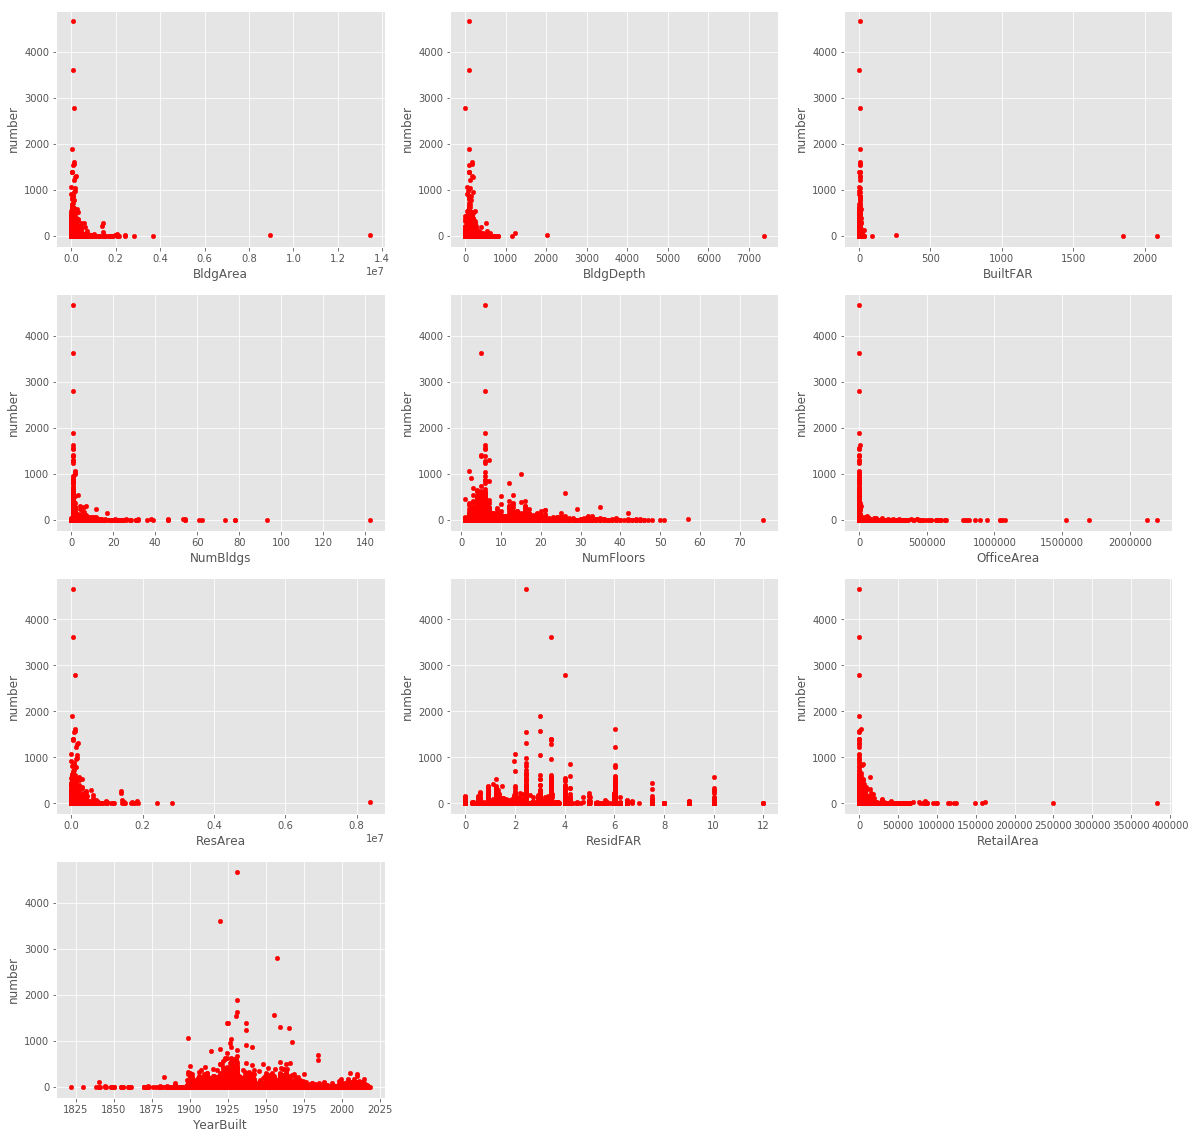

In [18]:
fig = plt.figure() # create figure

i = 0
row = (len(df_model.columns)-1) // 3 + 1
col = 3

ax = [0]*(len(df_model.columns)+1)

for i in range(1,len(df_model.columns)):
    ax[i] = fig.add_subplot(row, col, i) # add subplots

i=1

for f in df_model.columns:
    if f != 'complaint_type':
        df_model.plot(kind='scatter', x = f, y = 'complaint_type', ax = ax[i], figsize=(20,20), c='r')
        ax[i].set_xlabel(f)
        ax[i].set_ylabel('number')
        i+=1


In [19]:
# df_model.info()

In [20]:
df_model.loc[df_model['complaint_type'] <= 10, 'complaint_type'] = 0
df_model.loc[df_model['complaint_type'] !=0, 'complaint_type'] = 1
df_model.complaint_type = df_model.complaint_type.astype(str)
df_model.complaint_type.value_counts()

0    46539
1    10694
Name: complaint_type, dtype: int64

<b>Modeling</b>

In [21]:
X = df_model[['BldgArea', 'BldgDepth', 'BuiltFAR', 'NumBldgs',
       'NumFloors', 'OfficeArea', 'ResArea', 'RetailArea',
       'YearBuilt']]
y = df_model['complaint_type']


In [22]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=3)

In [23]:
complTree = DecisionTreeClassifier(criterion="entropy", max_depth = 4)
complTree.fit(X_train,y_train)
predTree = complTree.predict(X_test)

In [24]:
print("DecisionTrees's Accuracy: ", metrics.accuracy_score(y_test, predTree), 'with max_depth = ',4)

DecisionTrees's Accuracy:  0.8298194525334887 with max_depth =  4


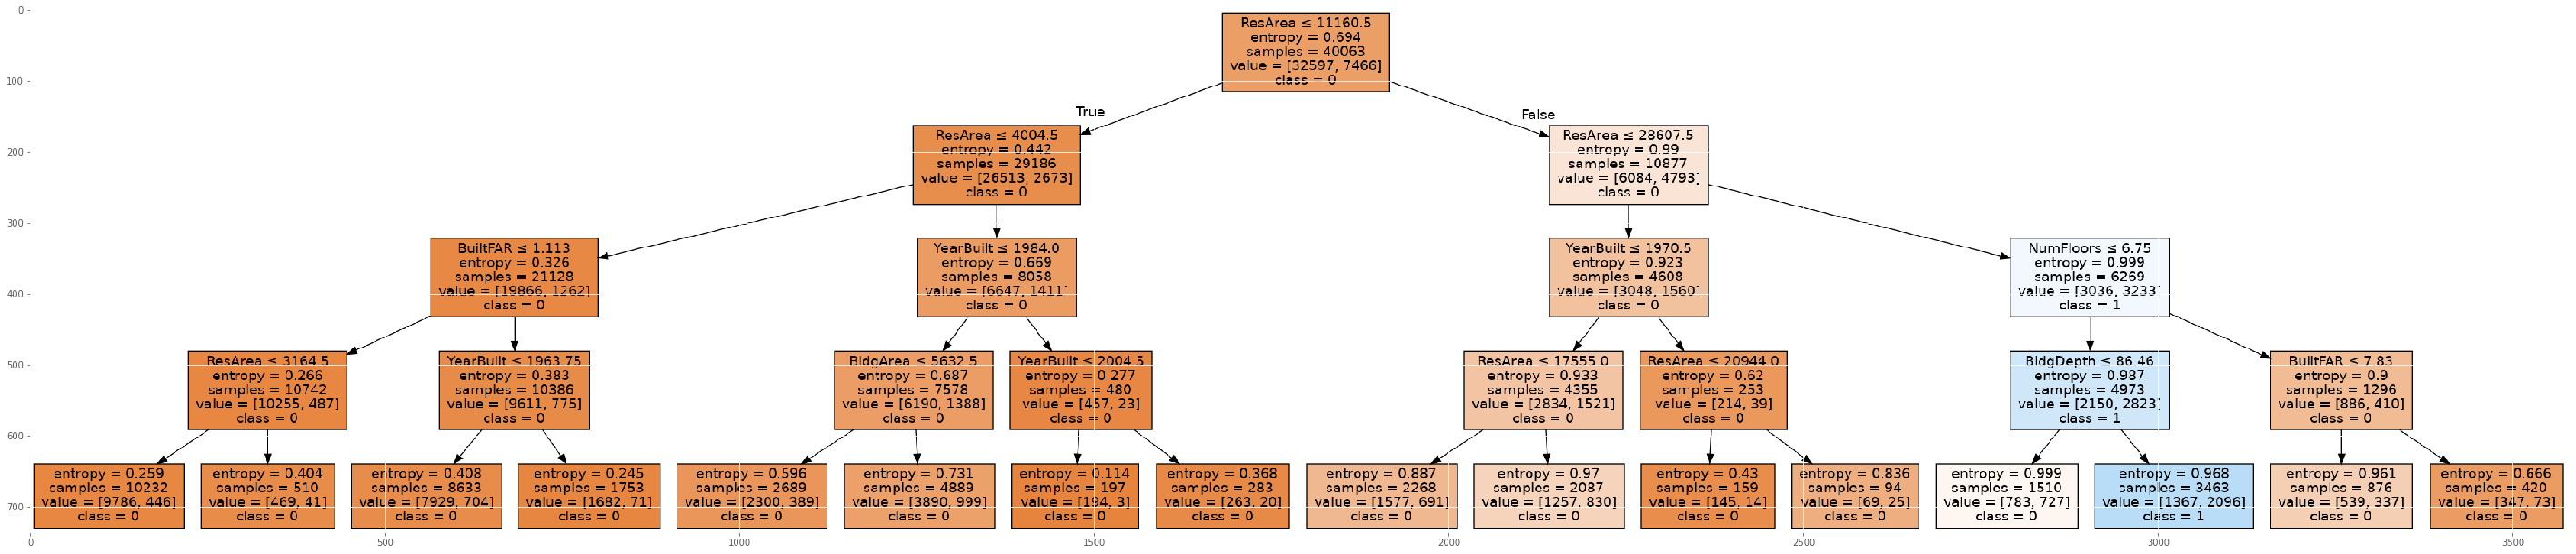

In [25]:
# Let's draw the TREE:

dot_data = StringIO()
filename = "compltree_task4.png"
featureNames = X.columns
targetNames = df_model["complaint_type"].unique().tolist()
out=tree.export_graphviz(complTree,feature_names=featureNames, out_file=dot_data, class_names= np.unique(y_train), filled=True,  special_characters=True,rotate=False)  
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
graph.write_png(filename)
img = mpimg.imread(filename)
plt.figure(figsize=(50, 120))
plt.imshow(img,interpolation='nearest')

In [26]:
print(dict(zip(X.columns, complTree.feature_importances_)))

{'BldgArea': 0.005544076496546992, 'BldgDepth': 0.008521033761453366, 'BuiltFAR': 0.01871132789496772, 'NumBldgs': 0.0, 'NumFloors': 0.03445030545553194, 'OfficeArea': 0.0, 'ResArea': 0.910495432678695, 'RetailArea': 0.0, 'YearBuilt': 0.02227782371280481}


<b>Top severe complaint prediction</b>

In [27]:
df_ds = df_merged[['created_date', 'complaint_type']]
df_ds = df_ds.loc[df_ds['complaint_type'] == 'HEAT/HOT WATER']
df_ds['created_date']=pd.to_datetime(df_ds['created_date'])
df_ds = df_ds.groupby('created_date').count()['complaint_type'].to_frame()
df_ds.index

DatetimeIndex(['2010-01-01', '2010-01-02', '2010-01-03', '2010-01-04',
               '2010-01-05', '2010-01-06', '2010-01-07', '2010-01-08',
               '2010-01-09', '2010-01-10',
               ...
               '2019-07-29', '2019-07-30', '2019-08-01', '2019-08-02',
               '2019-08-03', '2019-08-04', '2019-08-05', '2019-08-06',
               '2019-08-07', '2019-08-08'],
              dtype='datetime64[ns]', name='created_date', length=3505, freq=None)

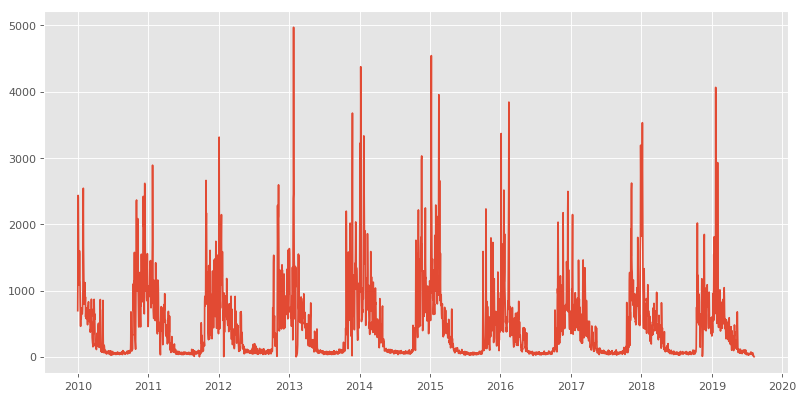

In [30]:
#convert to time series:
from matplotlib.pyplot import figure
ts = df_ds['complaint_type']
figure(num=None, figsize=(12, 6), dpi=80, facecolor='w', edgecolor='k')
plt.plot(ts)

<b>Modeling</b>

/opt/conda/envs/Python36/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/opt/conda/envs/Python36/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:191: FutureWarning: Creating a DatetimeIndex by passing range endpoints is deprecated.  Use `pandas.date_range` instead.
  start=index[0], end=index[-1], freq=freq)
/opt/conda/envs/Python36/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:336: FutureWarning: Creating a DatetimeIndex by passing range endpoints is deprecated.  Use `pandas.date_range` instead.
  freq=base_index.freq)
/opt/conda/envs/Python36/lib/python3.6/site-packages/statsmodels/tsa/holtwinters.py:322: FutureWarning: Addition/subtraction of integers and integer-arrays to Timestamp is deprecated, will be removed in a future version.  Instead of adding/subtracting `n`, use `n * self.freq`
  start = self.model._index[-1] 

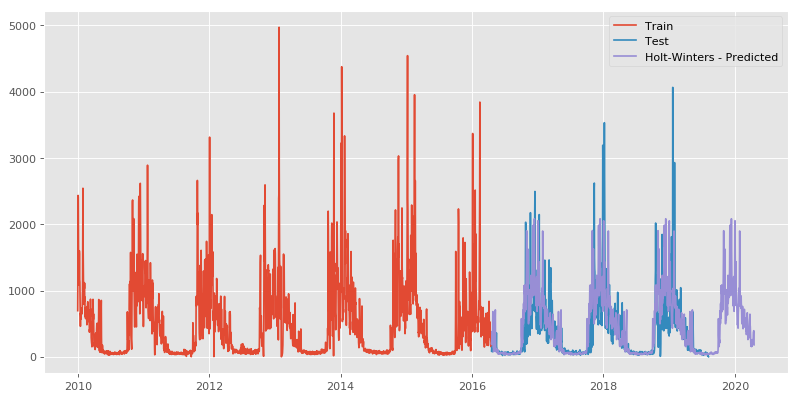

In [32]:
from statsmodels.tsa.holtwinters import ExponentialSmoothing
# ts.index.freq = 'D'
train, test = ts.iloc[:2300], ts.iloc[2300:]

model = ExponentialSmoothing(train, seasonal='mul', seasonal_periods=365).fit()
pred = model.predict(start=test.index[0], end=test.index[-1])
forecast = model.forecast(4*365)

figure(num=None, figsize=(12, 6), dpi=80, facecolor='w', edgecolor='k')
plt.plot(train.index, train, label='Train')
plt.plot(test.index, test, label='Test')
plt.plot(forecast.index, forecast, label='Holt-Winters - Predicted')
plt.legend(loc='best')



<b>Model Evaluation</b>

In [33]:
forecast_error = [test[i]-pred[i] for i in range(len(test))]
print('Mean Forecast Error: %s' % np.mean(forecast_error))
print('Mean Squared Error : %s' % np.mean(forecast_error)**2)
print('Mean Root Squared Error : %s' % np.sqrt(np.mean(forecast_error)**2))

from sklearn.metrics import mean_squared_error
from math import sqrt

mse = mean_squared_error(test, pred[:-2])
rmse = sqrt(mse)
print('RMSE: %f' % rmse)

Mean Forecast Error: -47.64787068872752
Mean Squared Error : 2270.319581169699
Mean Root Squared Error : 47.64787068872752
RMSE: 417.484974


<b>Conclusion</b>

Finally, two prediction models were built:

1. The first one was trained to identify the probability of facing 'HEAT/ HOT WATER' severe problems for a certain kind of housing.
2. The second one was trained to predict the number of complaints in the future for <b>all New York boroughs</b>.

These models are based on Decision Tree and HoltWinters algorithms respectively.
